# Procrastinate Pro+

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

#### Описание данных
Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица `orders_log_short` (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [3]:
visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [4]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [8]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [10]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

In [11]:
visits.session_start = pd.to_datetime(visits.session_start)
visits.session_end = pd.to_datetime(visits.session_end)
orders.event_dt = pd.to_datetime(orders.event_dt)
costs.dt = pd.to_datetime(costs.dt).dt.date

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

In [12]:
# функция для получения пользовательских профилей
def get_profiles(sessions, orders, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [13]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [14]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [15]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


In [16]:
# функция для сглаживания датафрейма
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [18]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [19]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [20]:
obs_date = datetime(2019, 11, 1).date()
hor_days = 14

In [21]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [22]:
max_date = profiles.first_ts.max().date()
min_date = profiles.first_ts.min().date()
print(f'Максимальная дата привлечения - {max_date}, минимальаня дата привлеченяи - {min_date}')

Максимальная дата привлечения - 2019-10-27, минимальаня дата привлеченяи - 2019-05-01


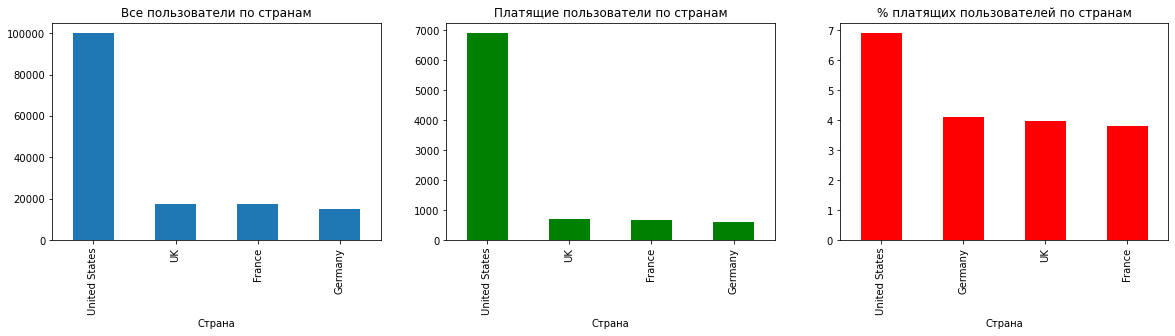

In [23]:
plt.figure(figsize=(20,4))
ax1 = plt.subplot(1,3,1)
profiles.groupby('region').user_id.nunique().sort_values(ascending=False).plot(kind='bar', ax=ax1)
plt.title('Все пользователи по странам')
plt.xlabel('Страна')

profiles[profiles.payer].groupby('region').user_id.nunique().sort_values(ascending=False).plot(
    kind='bar', ax=plt.subplot(1,3,2), color='green')
plt.title('Платящие пользователи по странам')
plt.xlabel('Страна')

(profiles[profiles.payer].groupby('region').user_id.nunique() 
 / profiles.groupby('region').user_id.nunique() * 100).sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(1,3,3), color='red')
plt.title('% платящих пользователей по странам')
plt.xlabel('Страна')
plt.show()

Большая часть пользователей приложения из США. Такяа ситуация и с обычными, и с платящими.  
Доли поьзователей из Великобритании, Германии и Франции находятся на одном уровне.  
При этом доля платящих пользователей в США не настолько выше, как количество пользователей, чем в других странах.

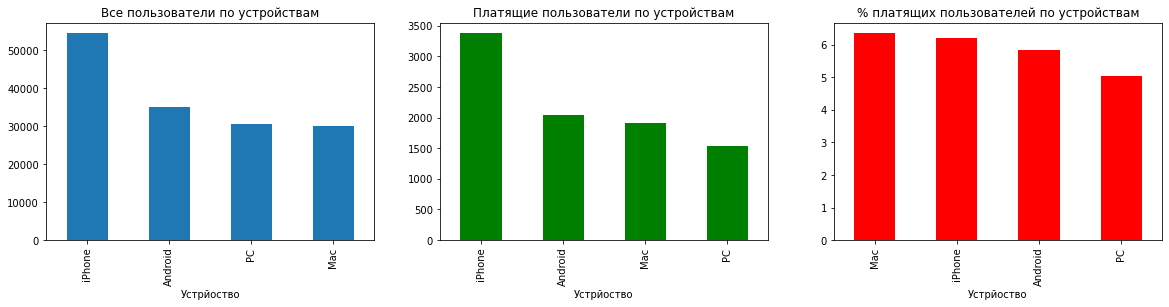

In [24]:
plt.figure(figsize=(20,4))
ax1 = plt.subplot(1,3,1)
profiles.groupby('device').user_id.nunique().sort_values(ascending=False).plot(kind='bar', ax=ax1)
plt.title('Все пользователи по устройствам')
plt.xlabel('Устрйоство')

profiles[profiles.payer].groupby('device').user_id.nunique().sort_values(ascending=False).plot(
    kind='bar', ax=plt.subplot(1,3,2), color='green')
plt.title('Платящие пользователи по устройствам')
plt.xlabel('Устрйоство')

(profiles[profiles.payer].groupby('device').user_id.nunique() 
 / profiles.groupby('device').user_id.nunique() * 100).sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(1,3,3), color='red')
plt.title('% платящих пользователей по устройствам')
plt.xlabel('Устрйоство')
plt.show()

Больщая часть обычных и платящих пользователей используют iPhone.  
Пользователи, использующие Mac и PC, на одном уровне, но количество платящих пользователей на Mac немного больше.  
Наилучший % платящих пользователей устрйоств Mac и iPhone.

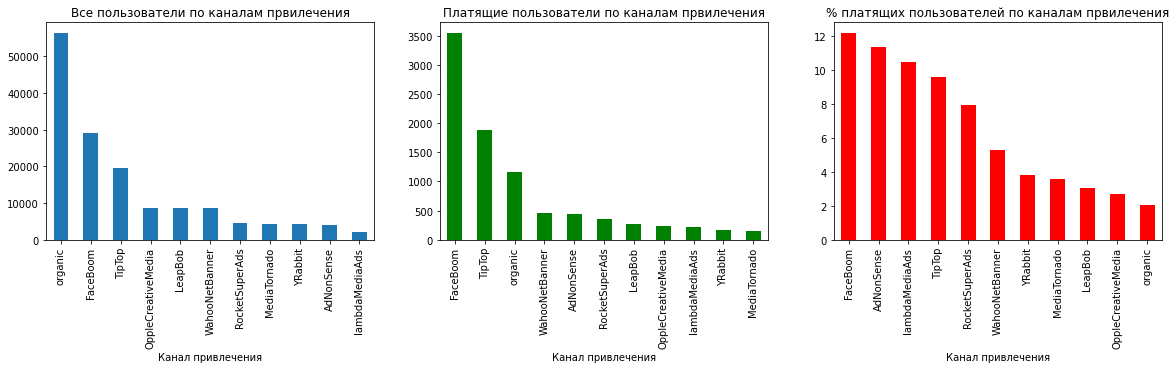

In [25]:
plt.figure(figsize=(20,4))
ax1 = plt.subplot(1,3,1)
profiles.groupby('channel').user_id.nunique().sort_values(ascending=False).plot(kind='bar', ax=ax1)
plt.title('Все пользователи по каналам првилечения')
plt.xlabel('Канал привлечения')

profiles[profiles.payer].groupby('channel').user_id.nunique().sort_values(ascending=False).plot(
    kind='bar', ax=plt.subplot(1,3,2), color='green')
plt.title('Платящие пользователи по каналам првилечения')
plt.xlabel('Канал привлечения')

(profiles[profiles.payer].groupby('channel').user_id.nunique() 
 / profiles.groupby('channel').user_id.nunique() * 100).sort_values(ascending=False).plot(kind='bar', ax=plt.subplot(1,3,3), color='red')
plt.title('% платящих пользователей по каналам првилечения')
plt.xlabel('Канал привлечения')
plt.show()

Больше всего пользователей находят приложение сами. Но они хуже всего используют платную версию.  
Платящих пользвоателей больше приходят с FaceBoom. Доля платящих пользователей с этого канала привлечения 12%.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [26]:
print(f'Всего с {min_date} по {max_date} на маркетинг потратили {costs.costs.sum()}')

Всего с 2019-05-01 по 2019-10-27 на маркетинг потратили 105497.30000000002


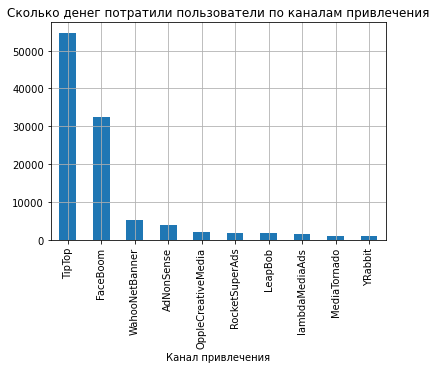

In [27]:
costs.groupby('channel').costs.sum().sort_values(ascending=False).plot(kind='bar', grid=True)
plt.title('Сколько денег потратили пользователи по каналам привлечения')
plt.xlabel('Канал привлечения')
plt.show()

Больше всего денег потратили пользователи, пришедшие с TipTop.  
Также выделяется FaceBoom.

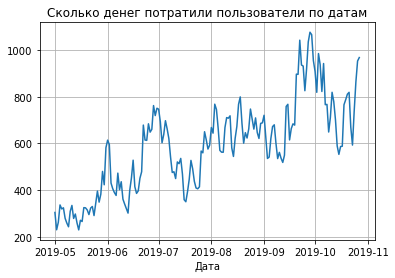

In [28]:
costs.groupby('dt').costs.sum().sort_values(ascending=False).plot(grid=True)
plt.title('Сколько денег потратили пользователи по датам')
plt.xlabel('Дата')
plt.show()

В оснвоном пользователи тратят в начале и в конце месяца. А вот в середине наблюдаются просадки.

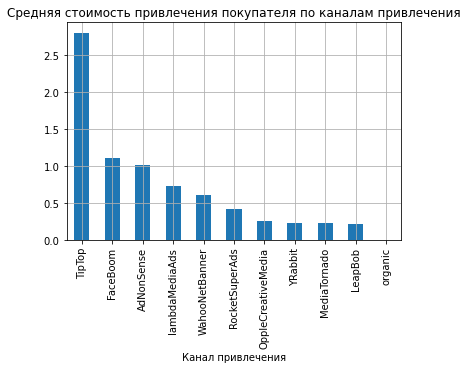

In [29]:
round(profiles.groupby('channel').acquisition_cost.mean().sort_values(ascending=False), 2).plot(kind='bar', grid=True)
plt.title('Средняя стоимость привлечения покупателя по каналам привлечения')
plt.xlabel('Канал привлечения')
plt.show()

Наиболее дорогая стоимость привлечения с TipTop. Но пользователи, пришедшии с этого канал, и потратили больше всех.

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

In [30]:
pay_profiles = profiles[profiles.channel != 'organic']

In [31]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(pay_profiles, orders, obs_date, hor_days)

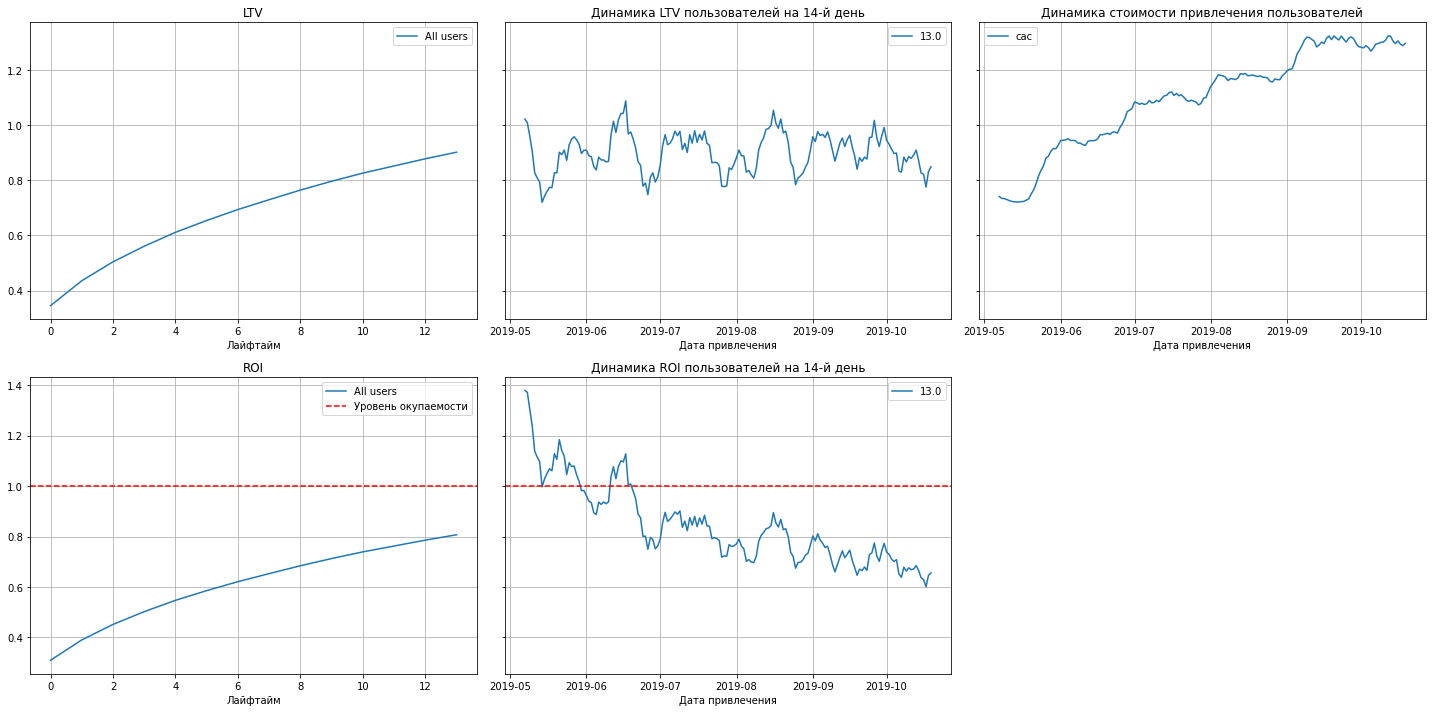

In [32]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, hor_days)

По графикам можно сделать такие выводы:
* Реклама не окупается.
* Динамика ROI резко снизилась в июне 2019, при этом CAC резко поднялся в тоже время. С дальнейшим ростом CAC ухудшался и ROI на 14 день.
* LTV выше у пользователей, пришедших летом в середине месяца. Осенью ситуация начинает меняться.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

In [33]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(pay_profiles, orders, obs_date, hor_days, ['device'])

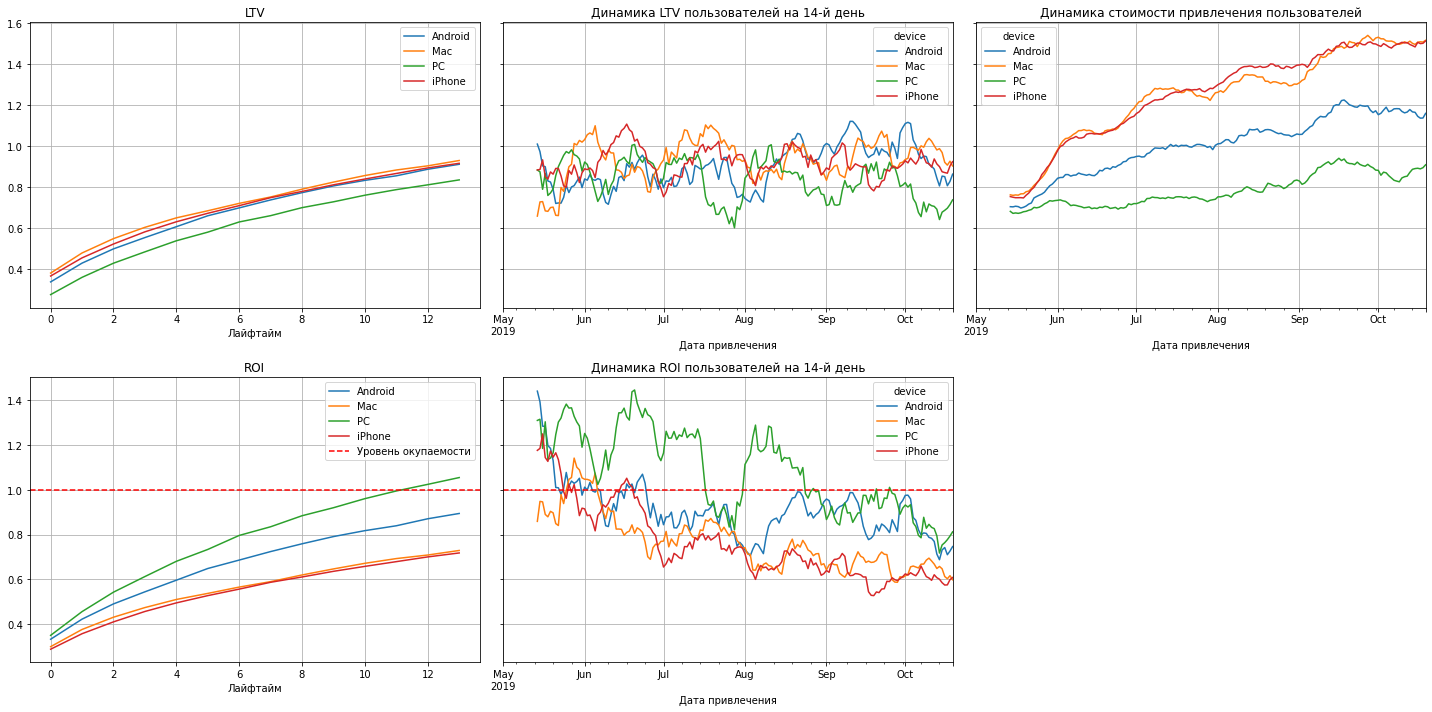

In [34]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, hor_days, 14)

Для пользователей PC реклама окупается, а вот для MAC и iPhone ROI на 14 дней менее 80%. Пользователи Android окупаются на 90%.
LTV же лучше всего у MAC и iPhone.  
Динамика ROI резко ухудшилась в июне, и в тоже время вырос CAC.  
Нужно проверить настройки рекламы.

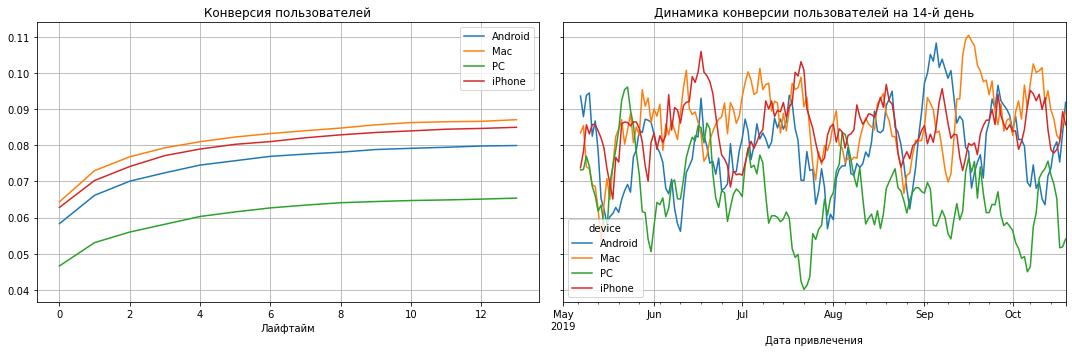

In [35]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    pay_profiles, orders, obs_date, hor_days, ['device']
)

plot_conversion(conversion_grouped, conversion_history, hor_days) 

Пользователи MAC, iPhone и Android конвертируются хорошо.  
Конверсия пользователей PC значительно ниже.

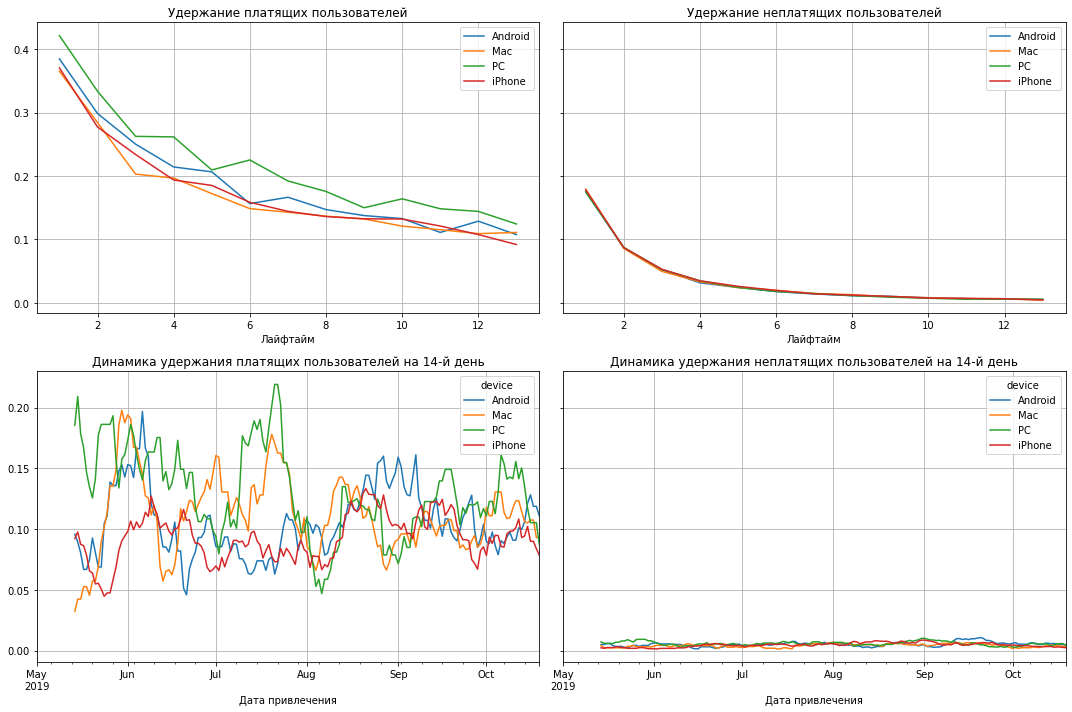

In [36]:
retention_raw, retention_grouped, retention_history = get_retention(
    pay_profiles, visits, obs_date, hor_days, ['device']
)

plot_retention(retention_grouped, retention_history, hor_days, 14) 

Удерживаются пользователи примерно одинаково на всех платформах. Немного лучше ситуация с пользователями PC.

### Проанализируйте окупаемость рекламы с разбивкой по странам

In [37]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(pay_profiles, orders, obs_date, hor_days, ['region'])

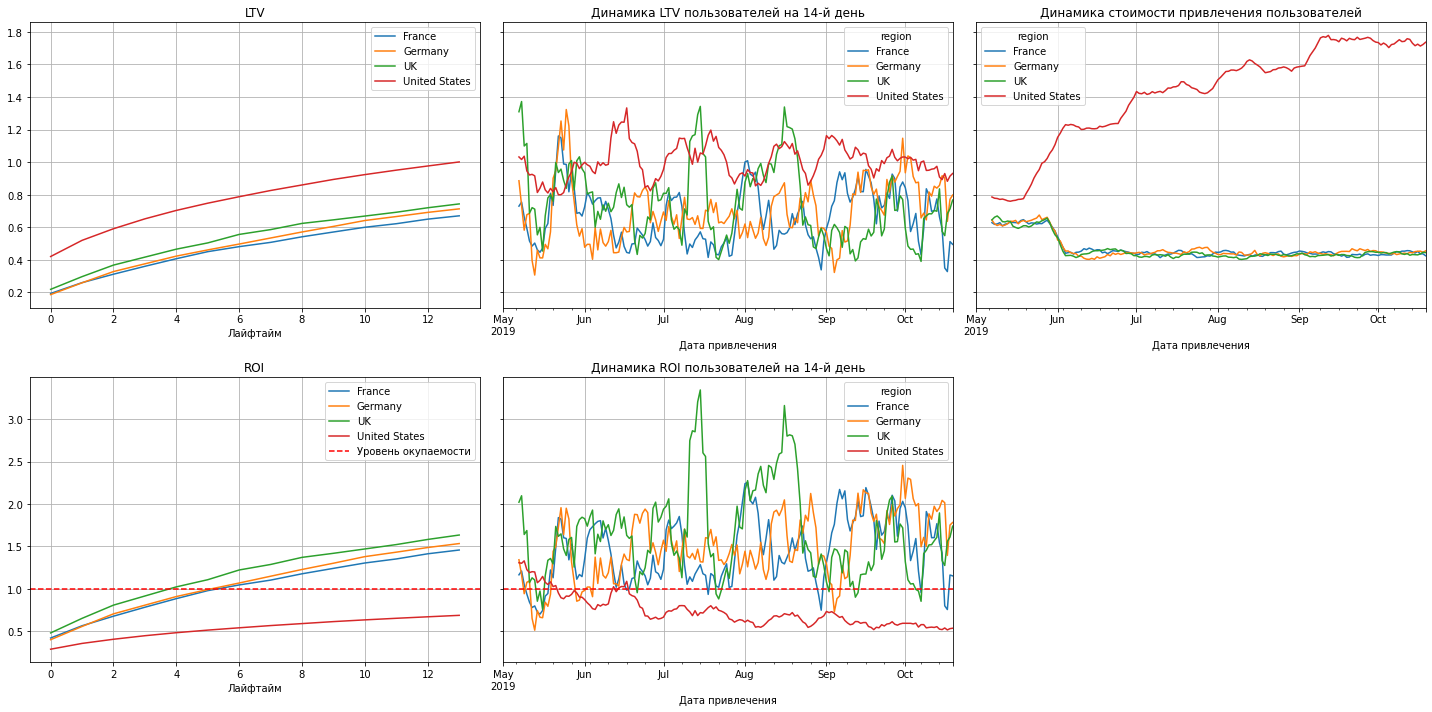

In [38]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, hor_days)

Не окупаются только пользователи из США - самая большая когорта.  
Также, как и в предыдущих графиках, наблюдается резкое снижение окупаемости в июне, и при этом резкое поднятие стоимости привлечения для пользователей из США. В то же время для других стран CAC снизился.

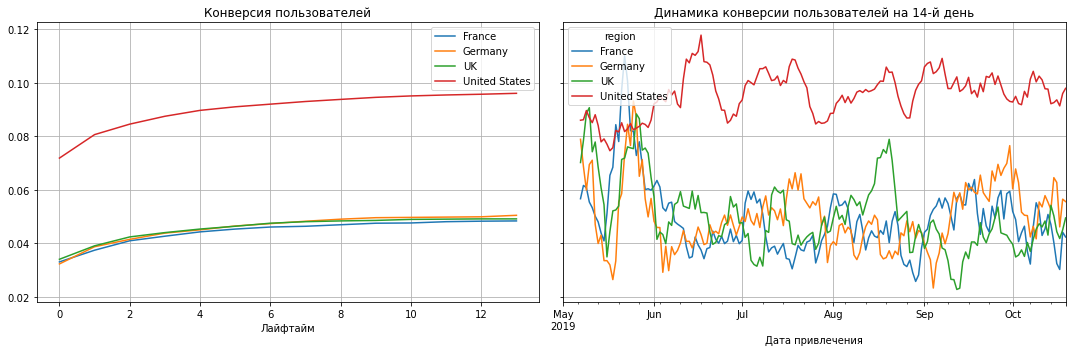

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    pay_profiles, orders, obs_date, hor_days, ['region']
)

plot_conversion(conversion_grouped, conversion_history, hor_days) 

При этом пользователи из США ковертируются очень хорошо.

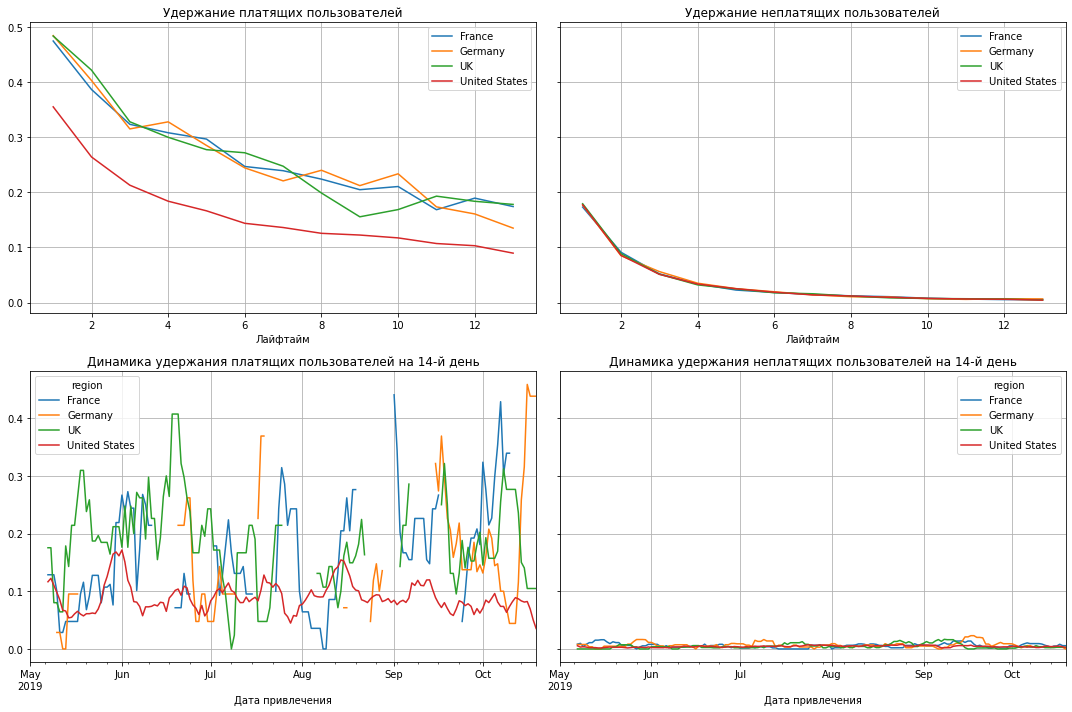

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    pay_profiles, visits, obs_date, hor_days, ['region']
)

plot_retention(retention_grouped, retention_history, hor_days) 

А вот удерживаются платящие пользователи из США значительно хуже. Нужно запросить у разработчиков информацию по ошибкам, возможно пользователи из США часто сталкиваются с техническими проблемами работы приложения.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

In [41]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(pay_profiles, orders, obs_date, hor_days, ['channel'])

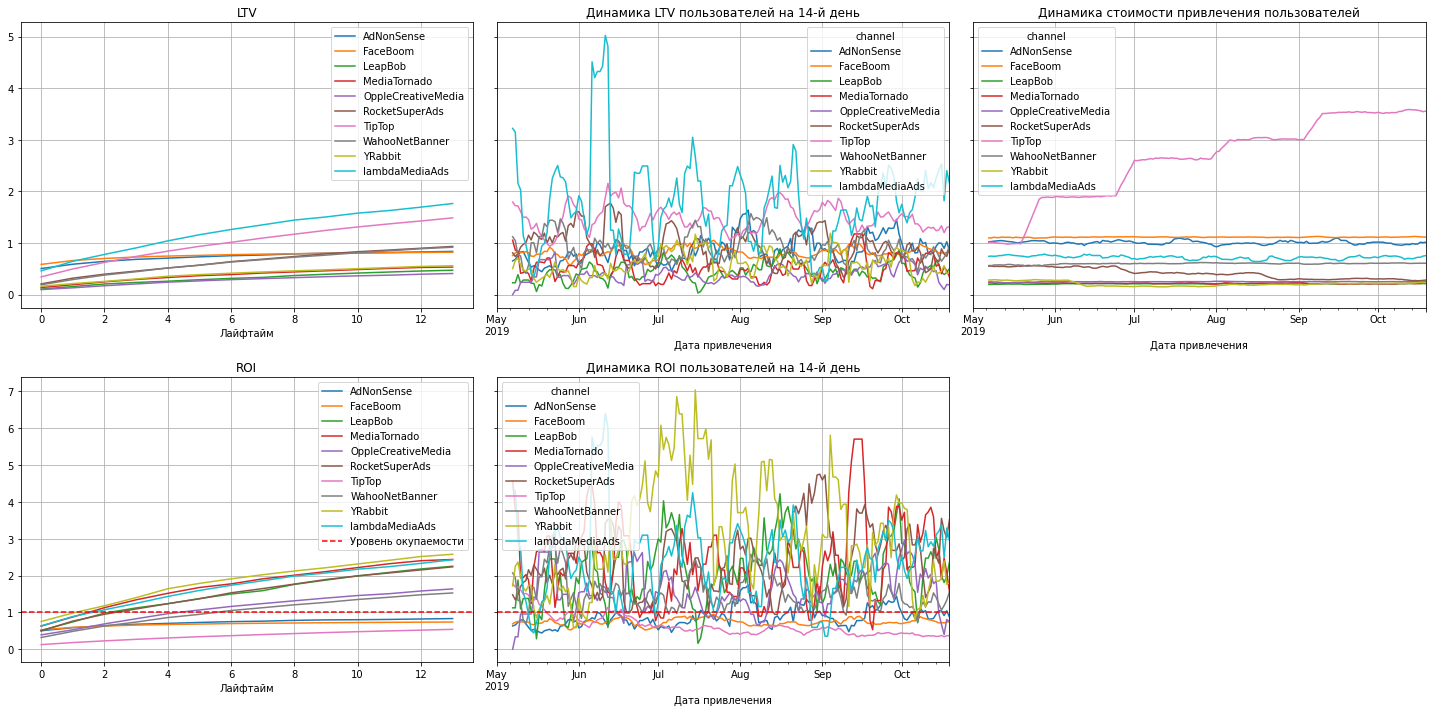

In [42]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, hor_days)

Не окупаются 3 рекламных источника:  TipTop, FaceBoom, AdNonSense. Это самые дорогие источники по стоимости привлечения пользователя.  
Все источники, кроме TipTop имеют достаточно стабильную стоимость привлечения. В TipTop же наблюдается больше увелечение стоимости.

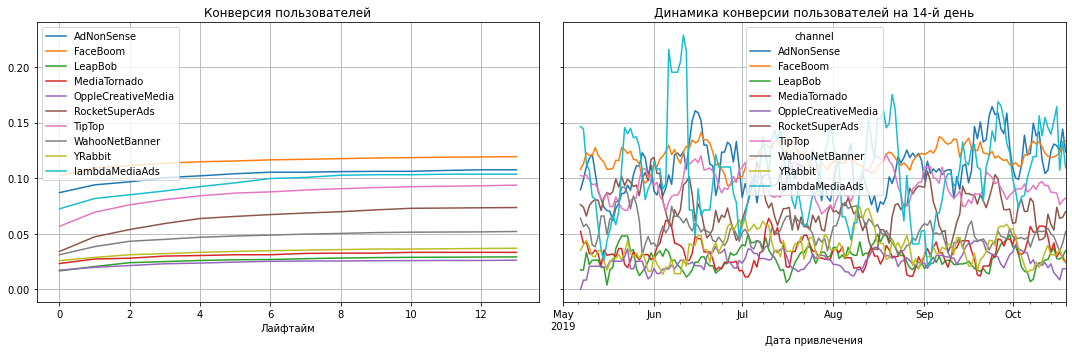

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    pay_profiles, orders, obs_date, hor_days, ['channel']
)

plot_conversion(conversion_grouped, conversion_history, hor_days) 

Лучше всего конвертируются пользователи с FaceBoom. Также хорошие показатели у AdNonSense, lambdaMediaAds и TipTop. 
Ситуация с остальными каналами значительно хуже.

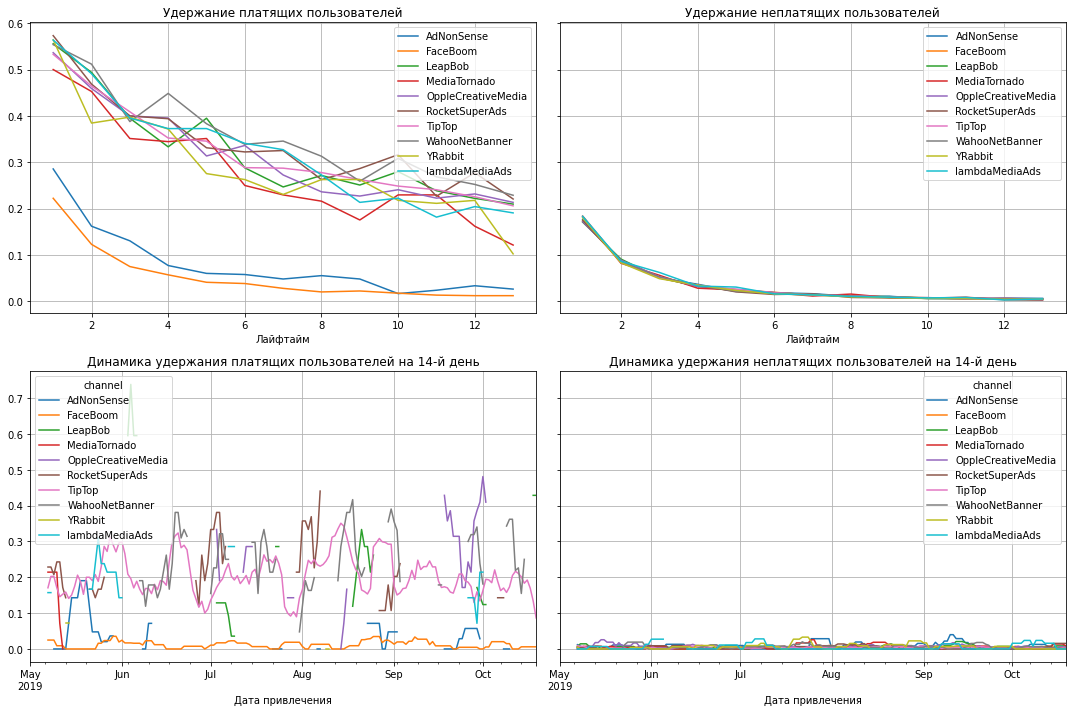

In [44]:
retention_raw, retention_grouped, retention_history = get_retention(
    pay_profiles, visits, obs_date, hor_days, ['channel']
)

plot_retention(retention_grouped, retention_history, hor_days) 

Хуже всего удерживаются платящие пользователи, пришедшие с FaceBoom и AdNonSense.
Стоит обратить внимание на рекламные настрйоки TipTop. Пользователи, пришедшие с этого канала, хорошо конвертируются и удерживаются, но при этом имеют очень высокую стоимость привлечения.  
От AdNonSense я бы рекомендовал отказаться.  
С FaceBoom ситуация достаточно сложная. Платящие пользователи плохо удерживаются, но хорошо конвертируются. Стоимость привлечения достаточно стабильная, но при этом реклама не окупается. По стоимости привлечения пользователя этот канал второй после самого дорого TipTop. При этом пользователи, пришедшие с этого канал, потратили достаточно мнго денег в приложении.

# Шаг 6. Напишите выводы
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Больше всего с 2019-05-01 по 2019-10-27 потратили пользователи, пришедшие с рекламных каналов TipTop и FaceBoom. Они имеюют самую дорогую стоимость привлечния. Это и является основной причиной их неокупаемости.  
От рекламы AdNonSense стоит отказаться. С этого канала получается наименьший profit.  

Большая часть пользователей нашего приложения находится в США, но стоимость их привлечения в разы дороже. Пользовтаели хорошо конвертируются, но плохо удерживаются. Стоит рассмотреть настройки рекламной компании.  
Такая же ситуация и с пользователями Android, iPhone и Mac. С ростом стоимости привлечения окупаемость стала хуже.

Во всех рассмотренных вариантах наблюдается проблема с рекламой. Стоит пересмотреть реклакмный бюджет и настройки по каждому из каналов.